In [1]:
import os
import pandas as pd
from datetime import datetime
import concurrent.futures
import cv2
from tqdm import tqdm
import numpy as np
from scipy.io import savemat, loadmat


In [14]:
processedDataFolder_name = "./processedData/2025-02-01_14-28-44/"
datasetFolder = "./datasets/image_data/"

In [2]:

image_data = []
for subdir, _, files in os.walk(datasetFolder):
    for file in files:
        if file.endswith(".jpg"):  
            file_path = os.path.join(subdir, file)
            renamedFile = file[:-4]
            renamedFiletimestamp = datetime.strptime(renamedFile, "%Y-%m-%d_%H_%M_%S_%f")
            renamedFileFormattedTime = renamedFiletimestamp.strftime("%Y-%m-%d %H:%M:%S.%f") + ".jpg"
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            date_str, time_hr,time_min,time_sec, microseconds = file[:-4].split("_")
            datetime_str = f"{date_str} {time_hr}:{time_min}:{time_sec}.{microseconds}"
            timestamp = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S.%f")
            formatted_timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S.%f")
            # print(formatted_timestamp)
            image_data.append([formatted_timestamp, image, renamedFileFormattedTime, file_path])

rgbCsvDF = pd.DataFrame(image_data, columns=[ "datetime", "rgbImage","rgbFilename", "rgbFilepath"])
rgbCsvDF["datetime"] = pd.to_datetime(rgbCsvDF["datetime"], format="%Y-%m-%d %H:%M:%S.%f")
rgbCsvPath = os.path.join(processedDataFolder_name, "rgbImage.csv")
rgbCsvDF.to_csv(rgbCsvPath, index=False)
rgbCsvDF.to_pickle(processedDataFolder_name + "rgbImage.pkl")
print(f"pkl file saved at: {rgbCsvPath}")

pkl file saved at: ./processedData/2025-02-01_14-28-44/rgbImage.csv


In [3]:
rgbCsvDF.head(4)

                    datetime  ...                                        rgbFilepath
0 2024-10-02 20:21:30.749866  ...  ./datasets/image_data/2024-10-02_20_20_33/2024...
1 2024-10-02 20:21:46.797354  ...  ./datasets/image_data/2024-10-02_20_20_33/2024...
2 2024-10-02 20:21:20.323423  ...  ./datasets/image_data/2024-10-02_20_20_33/2024...
3 2024-10-02 20:22:06.702628  ...  ./datasets/image_data/2024-10-02_20_20_33/2024...

[4 rows x 4 columns]


In [6]:
mergedRadarDepth = processedDataFolder_name + "mergedRadarDepth.pkl" 
mergedRadarDepth = pd.read_pickle(mergedRadarDepth)
mergedRadarDepth.reset_index(drop=True, inplace=True)

Traceback (most recent call last):
  File "/root/.vscode-server/extensions/ms-python.python-2024.22.2-linux-x64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 1, in <module>
NameError: name 'processedDataFolder_name' is not defined



In [5]:

rgbCsvDF = rgbCsvDF.sort_values(by='datetime', ascending=True)
mergedRadarDepth = mergedRadarDepth.sort_values(by='datetime', ascending=True)
    

In [7]:
mergedPcdDepthRgb = pd.merge_asof(mergedRadarDepth, rgbCsvDF, on='datetime',tolerance=pd.Timedelta('0.5ms'), direction='nearest')#change ms
print("mergedPcdDepthRgb.shape: ",mergedPcdDepthRgb.shape)
mergedPcdDepthRgb =mergedPcdDepthRgb.dropna(subset=['rgbFilename'])
print("1ms - mergedPcdDepthRgb after dropna.shape: ",mergedPcdDepthRgb.shape)


mergedPcdDepthRgb.shape:  (2033, 6)
1ms - mergedPcdDepthRgb after dropna.shape:  (10, 6)


In [33]:
mergedPcdDepthRgb.to_csv(processedDataFolder_name + "mergedPcdDepthRgb.csv", index=False)
mergedPcdDepthRgb.to_pickle(processedDataFolder_name + "mergedPcdDepthRgb.pkl")
print("mergerdPcdDepthRgb.pkl Exported")

mergerdPcdDepthRgb.pkl Exported


In [15]:
mergedPcdDepthRgb = pd.read_pickle(processedDataFolder_name + "mergerdPcdDepthRgb.pkl")

In [17]:
nedFilePath = os.path.join("./datasets/telemetry_data/")
filteredNedFile = [f for f in os.listdir(nedFilePath) if os.path.isfile(os.path.join(nedFilePath, f)) and f.endswith('.csv') and not f.startswith('only_sensor')]

def load_and_process_file(filename):
    try:
        df = pd.read_csv(nedFilePath+filename)
        print(f"Processing {filename}")
        df['nedFilename'] = filename  
        return df
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None 


In [18]:

with concurrent.futures.ProcessPoolExecutor(max_workers=5) as file_executor:
        results = list(file_executor.map(load_and_process_file, filteredNedFile))
processedNedFiles = [df for df in results if df is not None]
if processedNedFiles:
    nedDf = pd.concat(processedNedFiles, ignore_index=True)
    nedDf = nedDf[["datetime","x_m","y_m","z_m","roll_rad_s","pitch_rad_s","yaw_rad_s","nedFilename"]]
    nedDf['datetime'] = pd.to_datetime(nedDf['datetime'])
    nedDf = nedDf.dropna()
    print(nedDf.head())  
else:
    print("No files were processed successfully.")

Processing 2024-10-30_17_37_31_telemtry.csvProcessing 2024-11-05_17_14_47_telemtry.csv

Processing 2024-10-30_15_33_50_telemtry.csv
Processing 2024-11-05_17_29_23_telemtry.csv
Processing 2024-10-30_17_38_28_telemtry.csv
Processing 2025-01-29_12_35_22_telemtry.csv
Processing 2025-01-29_12_49_07_telemtry.csv
Processing 2025-01-29_13_09_10_telemtry.csv
                    datetime       x_m       y_m       z_m  roll_rad_s  \
0 2025-01-29 12:35:23.430650 -0.000095 -0.000030 -0.848082    0.000759   
1 2025-01-29 12:35:23.461294 -0.000095 -0.000051 -0.848245    0.001361   
2 2025-01-29 12:35:23.491600 -0.000097 -0.000062 -0.848318    0.000385   
3 2025-01-29 12:35:23.528851 -0.000099 -0.000081 -0.848448    0.000942   
4 2025-01-29 12:35:23.560871 -0.000101 -0.000094 -0.848530   -0.000049   

   pitch_rad_s  yaw_rad_s                       nedFilename  
0     0.000239   0.000197  2025-01-29_12_35_22_telemtry.csv  
1    -0.000255  -0.000430  2025-01-29_12_35_22_telemtry.csv  
2    -0.000264   

In [19]:

nedDf = nedDf.sort_values(by='datetime', ascending=True)
mergerdPcdDepthRgb = mergedPcdDepthRgb.sort_values(by='datetime', ascending=True)
    

In [20]:
mergedPcdDepthRgbNed = pd.merge_asof(mergedPcdDepthRgb, nedDf, on='datetime',tolerance=pd.Timedelta('1000ms'), direction='nearest')
print("mergerdPcdDepthRgbNed.shape: ",mergedPcdDepthRgbNed.shape)
mergedPcdDepthRgbNed =mergedPcdDepthRgbNed.dropna(subset=["nedFilename"])
print("1000ms - mergerdPcdDepthRgbNed after dropna.shape: ",mergedPcdDepthRgbNed.shape)

mergerdPcdDepthRgbNed.shape:  (1145, 13)
1000ms - mergerdPcdDepthRgbNed after dropna.shape:  (252, 13)


In [21]:
mergedPcdDepthRgbNed.to_csv(processedDataFolder_name + "mergedPcdDepthRgbNed.csv", index=False)
mergedPcdDepthRgbNed.to_pickle(processedDataFolder_name + "mergedPcdDepthRgbNed.pkl")
print("mergedPcdDepthRgbNed.pkl Exported")

PermissionError: [Errno 13] Permission denied: './processedData/2025-02-01_14-28-44/mergedPcdDepthRgbNed.csv'

In [ ]:
#exporting the pkl for test on slidesr
outputDirAll = processedDataFolder_name + "droneData_All/processedData/"  
txt_file_All = processedDataFolder_name + "droneData_All/datalist.txt" 

os.makedirs(outputDirAll, exist_ok=True)

with open(txt_file_All, "w") as all_out:
    for idx,row in tqdm(mergedPcdDepthRgb.iterrows(), desc="Saving All Data", total=len(mergedPcdDepthRgb)):
        # row = mergedPcdDepthRgb.iloc[idx]
        # mat_file_name = f"{idx + 1}_mmwave.mat"
        timestampStr, fTimestampStr = mergedPcdDepthRgb["rgbFilename"][idx].split(".")[:-1]
        matName = f"{timestampStr}.{fTimestampStr}"
        mat_file_name = f"{matName}_mmwave.mat"
        mat_file_path = os.path.join(outputDirAll, mat_file_name)

        savemat(mat_file_path, {
            'radarPCD': mergedPcdDepthRgb['radarPCD'][idx],
            'depthPCD': mergedPcdDepthRgb['depthPCD'][idx],
            'datetime': mergedPcdDepthRgb['datetime'][idx]
        })
        all_out.write(mat_file_path + "\n")
print(f"Exported {len(mergedPcdDepthRgb)} testing .mat files to '{outputDirAll}' and recorded in '{txt_file_All}'.")

with open(txt_file_All, "r") as f:
    mat_file_paths = [line.strip() for line in f.readlines() if line.strip().endswith(".mat")]

mat_filenames = [path.split("/")[-1] for path in mat_file_paths]
mat_filenames_array = np.array(mat_filenames)

Exported 10 testing .mat files to './processedData/2025-02-01_14-28-44/droneData_All/processedData/' and recorded in './processedData/2025-02-01_14-28-44/droneData_All/datalist.txt'.


In [ ]:
with open(txt_file_All, "r") as f:
        mat_file_paths = [line.strip() for line in f.readlines() if line.strip().endswith(".mat")]

mat_filenames = [path.split("/")[-1] for path in mat_file_paths]
mat_filenames_array = np.array(mat_filenames)

In [ ]:
mat_filenames_array

['2024-10-02 20:21:00.599691_mmwave.mat'
 '2024-10-02 20:21:20.399870_mmwave.mat'
 '2024-10-02 20:21:39.399616_mmwave.mat'
 '2024-10-02 20:21:46.999942_mmwave.mat'
 '2024-10-02 20:27:21.199901_mmwave.mat'
 '2024-10-02 20:29:59.600329_mmwave.mat'
 '2025-01-29 12:41:51.200103_mmwave.mat'
 '2025-01-29 12:41:53.199948_mmwave.mat'
 '2025-01-29 12:41:53.600438_mmwave.mat'
 '2025-01-29 12:43:06.199806_mmwave.mat']


In [ ]:
all_files = os.listdir(resultMatFolderPath)
folder_path = processedDataFolder_name + "visualization/testResultAll"

In [ ]:
all_files

['2024-10-02 20:21:20.399870_mmwave.mat', '2025-01-29 12:41:53.600438_mmwave.mat', '2024-10-02 20:21:46.999942_mmwave.mat', '2025-01-29 12:41:51.200103_mmwave.mat', '2025-01-29 12:41:53.199948_mmwave.mat', '2024-10-02 20:27:21.199901_mmwave.mat', '2024-10-02 20:21:39.399616_mmwave.mat', '2024-10-02 20:21:00.599691_mmwave.mat', '2024-10-02 20:29:59.600329_mmwave.mat', '2025-01-29 12:43:06.199806_mmwave.mat']


In [ ]:
mat_files = [file for file in all_files if file.endswith('.mat')]

In [ ]:
mat_files

['2024-10-02 20:21:20.399870_mmwave.mat', '2025-01-29 12:41:53.600438_mmwave.mat', '2024-10-02 20:21:46.999942_mmwave.mat', '2025-01-29 12:41:51.200103_mmwave.mat', '2025-01-29 12:41:53.199948_mmwave.mat', '2024-10-02 20:27:21.199901_mmwave.mat', '2024-10-02 20:21:39.399616_mmwave.mat', '2024-10-02 20:21:00.599691_mmwave.mat', '2024-10-02 20:29:59.600329_mmwave.mat', '2025-01-29 12:43:06.199806_mmwave.mat']


In [ ]:
mat_file = '2024-10-02 20:21:20.399870_mmwave.mat'

Traceback (most recent call last):
  File "/root/.vscode-server/extensions/ms-python.python-2024.22.2-linux-x64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 1
    mat_file = '2024-10-02 20:21:20.399870_mmwave.mat'"
                                                      ^
SyntaxError: EOL while scanning string literal



In [ ]:
print(mat_file.split("_")[0])

2024-10-02 20:21:20.399870


In [ ]:
timestampStr = mat_file.split("_")[0]


Traceback (most recent call last):
  File "/root/.vscode-server/extensions/ms-python.python-2024.22.2-linux-x64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 1, in <module>
ValueError: not enough values to unpack (expected 5, got 1)



In [ ]:
timestampStr = datetime.strptime(timestampStr, "%Y-%m-%d %H:%M:%S.%f")
rgbFileNa = timestampStr.strftime("%Y-%m-%d %H:%M:%S.%f") + ".jpg"
print(rgbFileNa)

2024-10-02 20:21:20.399870.jpg


In [ ]:
rgbFilePt = mergedPcdDepthRgb.loc[mergedPcdDepthRgb['rgbFilename'] == rgbFileNa, 'rgbFilepath'].iloc[0]


In [ ]:
rgbFilePt

./datasets/image_data/2024-10-02_20_20_33/2024-10-02_20_21_20_399870.jpg


In [ ]:
rgbFilePt = mergedPcdDepthRgb.loc[mergedPcdDepthRgb['rgbFilename'] == rgbFileNa, 'rgbFilepath']
if not rgbFilePt.empty:
    rgbFilePt = rgbFilePt.iloc[0]  # Safe access
else:
    rgbFilePt = None

In [ ]:
rgbFilePt

./datasets/image_data/2024-10-02_20_20_33/2024-10-02_20_21_20_399870.jpg


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from utils.helper import *
# from app.utils.helper import *
import gc
import time

In [3]:
total_frameDepth = pd.DataFrame(columns=["datetime","depthPCD"])
totalDepthFrame = []
totalDepthFrameTimestamps = []

In [4]:
with open("./datasets/depth_data/drone_2025-01-29_12_41_45_test_depth.pkl", "rb") as f:
    depthObj = pickle.load(f)

In [5]:
depthObj

[[array([(-1.0291497 , -0.74916923, 1.9380001),
         (-1.0259585 , -0.74916923, 1.9380001),
         (-1.0227672 , -0.74916923, 1.9380001), ...,
         ( 0.26567972,  0.20628215, 0.513    ),
         ( 0.26652446,  0.20628215, 0.513    ),
         ( 0.26736918,  0.20628215, 0.513    )],
        dtype=[('f0', '<f4'), ('f1', '<f4'), ('f2', '<f4')]),
  '2025-01-29 12:41:46.829741'],
 [array([(-1.0227773 , -0.74453044, 1.9260001),
         (-1.0196059 , -0.74453044, 1.9260001),
         (-1.0164343 , -0.74453044, 1.9260001), ...,
         ( 0.2651618 ,  0.20588005, 0.512    ),
         ( 0.26600492,  0.20588005, 0.512    ),
         ( 0.266848  ,  0.20588005, 0.512    )],
        dtype=[('f0', '<f4'), ('f1', '<f4'), ('f2', '<f4')]),
  '2025-01-29 12:41:46.927161'],
 [array([(-1.019591  , -0.742211  , 1.9200001),
         (-1.0164294 , -0.742211  , 1.9200001),
         (-1.0132679 , -0.742211  , 1.9200001), ...,
         ( 0.26567972,  0.20628215, 0.513    ),
         ( 0.26652446,  0

In [6]:
i=10
x = depthObj[i][0]['f0']
y = depthObj[i][0]['f1']
z = depthObj[i][0]['f2']

In [7]:
print(x)
print(y)
print(z)

[-1.0259634  -1.0227822  -1.0164343  ...  0.2672334   0.2680831
  0.26893276]
[-0.74684983 -0.74684983 -0.74453044 ...  0.20748849  0.20748849
  0.20748849]
[1.932      1.932      1.9260001  ... 0.51600003 0.51600003 0.51600003]


In [8]:
frame = np.array([x, y, z])
frame

array([[-1.0259634 , -1.0227822 , -1.0164343 , ...,  0.2672334 ,
         0.2680831 ,  0.26893276],
       [-0.74684983, -0.74684983, -0.74453044, ...,  0.20748849,
         0.20748849,  0.20748849],
       [ 1.932     ,  1.932     ,  1.9260001 , ...,  0.51600003,
         0.51600003,  0.51600003]], dtype=float32)

In [9]:
frameT = np.array([x, y, z]).T
frameT

array([[-1.0259634 , -0.74684983,  1.932     ],
       [-1.0227822 , -0.74684983,  1.932     ],
       [-1.0164343 , -0.74453044,  1.9260001 ],
       ...,
       [ 0.2672334 ,  0.20748849,  0.51600003],
       [ 0.2680831 ,  0.20748849,  0.51600003],
       [ 0.26893276,  0.20748849,  0.51600003]], dtype=float32)

In [35]:
x, y, z = frame[0, :], frame[1, :], frame[2, :]

In [11]:
x, z, y = frame[0, :], frame[1, :], frame[2, :]

/tmp/ipykernel_1055439/1310843871.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, cmap='viridus', s=1, label="Depth Point Cloud")


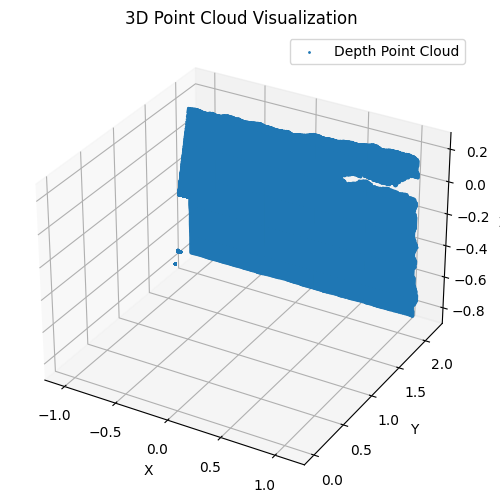

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, cmap='viridus', s=1, label="Depth Point Cloud")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud Visualization')
ax.legend()
plt.savefig(f"d1.png", dpi=300, bbox_inches='tight')

plt.show()

In [39]:
x, y, z = frameT[:,0], frameT[:,1], frameT[:,2]

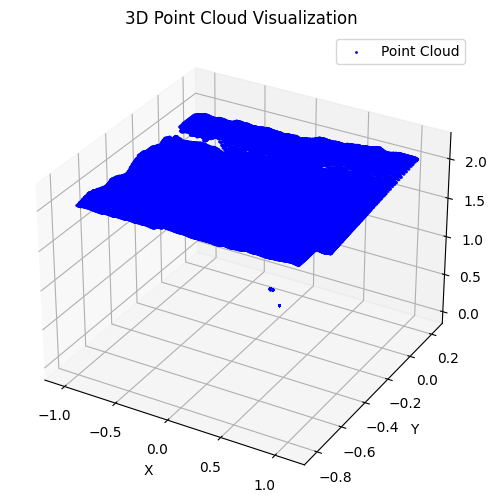

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(x, y, z, c='blue', marker='o', s=1, label="Point Cloud")

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud Visualization')
ax.legend()
plt.show()

In [45]:
folderPath = processedDataFolder_name + "visualization/testResultAll/"
all_files = os.listdir(folderPath)

predImages = [file for file in all_files if file.endswith('.png') and file.startswith("2025")]


In [46]:
predImages

['2025-01-29 12:42:59.789583_mmwave.mat.png',
 '2025-01-29 12:42:26.178795_mmwave.mat.png',
 '2025-01-29 12:42:26.810417_mmwave.mat.png',
 '2025-01-29 12:41:48.410860_mmwave.mat.png',
 '2025-01-29 12:42:39.337433_mmwave.mat.png',
 '2025-01-29 12:42:12.991434_mmwave.mat.png',
 '2025-01-29 12:42:51.982066_mmwave.mat.png',
 '2025-01-29 12:42:11.809286_mmwave.mat.png',
 '2025-01-29 12:41:50.182913_mmwave.mat.png',
 '2025-01-29 12:42:27.875552_mmwave.mat.png',
 '2025-01-29 12:43:06.810315_mmwave.mat.png',
 '2025-01-29 12:42:27.197853_mmwave.mat.png',
 '2025-01-29 12:42:27.594033_mmwave.mat.png',
 '2025-01-29 12:41:48.612145_mmwave.mat.png',
 '2025-01-29 12:43:00.393387_mmwave.mat.png',
 '2025-01-29 12:42:12.790978_mmwave.mat.png',
 '2025-01-29 12:41:47.015956_mmwave.mat.png',
 '2025-01-29 12:43:12.226335_mmwave.mat.png',
 '2025-01-29 12:43:06.583838_mmwave.mat.png',
 '2025-01-29 12:43:00.791083_mmwave.mat.png',
 '2025-01-29 12:41:47.207420_mmwave.mat.png',
 '2025-01-29 12:42:27.411360_mmwav

In [23]:
import scipy.io

resultMatFolderPath = processedDataFolder_name + "outputDroneAll/"
# current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timeDir = processedDataFolder_name.split("/")[-2]
#enable it when multiple test scenios required
# folder_path = os.path.join(resultMatFolderPath, timeDir)
folder_path = resultMatFolderPath

In [24]:
all_files = os.listdir(resultMatFolderPath)
folder_path = processedDataFolder_name + "visualization/testResultAll"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")


mat_files = [file for file in all_files if file.endswith('.mat')]
progressBar = tqdm(mat_files, desc="Plotting .mat files")
for mat_file in progressBar:
    progressBar.set_postfix(file=mat_file)
    file_path = os.path.join(resultMatFolderPath, mat_file)
    mat_data = scipy.io.loadmat(file_path)
    header = ['input', 'pred_pcd', 'gt_pcd', 'Chd', 'EMD']

    input_points = mat_data['input']
    pred_points = mat_data['pred_pcd']
    gt_points = mat_data['gt_pcd']


    fig = plt.figure(figsize=(20, 7))
    fig.suptitle(f"Point Cloud Visualization: {mat_file}", fontsize=7, fontweight='bold')  # Main title

    ax1 = fig.add_subplot(141, projection='3d')
    scatter1 = ax1.scatter(input_points[:, 0], input_points[:, 1], input_points[:, 2], 
                        c=input_points[:, 2], cmap='viridis', s=1)
    ax1.set_title("Input Point Cloud")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    ax2 = fig.add_subplot(142, projection='3d')
    scatter2 = ax2.scatter(pred_points[:, 0], pred_points[:, 1], pred_points[:, 2], 
                        c=pred_points[:, 2], cmap='viridis', s=1)
    ax2.set_title("Predicted Point Cloud")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax3 = fig.add_subplot(143, projection='3d')
    scatter3 = ax3.scatter(gt_points[:, 0], gt_points[:, 1], gt_points[:, 2], 
                        c=gt_points[:, 2], cmap='viridis', s=1)
    ax3.set_title("Ground Truth Point Cloud")
    ax3.set_xlabel("X")
    ax3.set_ylabel("Y")
    ax3.set_zlabel("Z")

    ax4 = fig.add_subplot(144)
    timestampStr = mat_file.split("_")[0]

    timestampStr = datetime.strptime(timestampStr, "%Y-%m-%d %H:%M:%S.%f")
    rgbFileNa = timestampStr.strftime("%Y-%m-%d %H:%M:%S.%f") + ".jpg"
    # print(rgbFileNa)
    rgbFilePt = mergedPcdDepthRgb.loc[mergedPcdDepthRgb['rgbFilename'] == rgbFileNa, 'rgbFilepath']
    if not rgbFilePt.empty:
        rgbFilePt = rgbFilePt.iloc[0] 
    else:
        rgbFilePt = None
    img = Image.open(rgbFilePt)

    ax4.imshow(img)  # Display the RGB image
    ax4.set_title("RGB Image")
    ax4.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.savefig(f"{folder_path}/new/{mat_file}.png", dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close(fig)

Folder './processedData/2025-02-01_14-28-44/visualization/testResultAll' already exists.


Plotting .mat files: 100%|██████████| 685/685 [00:00<00:00, 950.55it/s, file=2024-10-02 20:21:21.213018_mmwave.mat] 
